# Coursework 1: Flight Prediciton (Samuel Hope)

## Import Data and Dependancies

In [1]:
import pandas as pd
import psutil
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, randint
from sklearn.model_selection import train_test_split,  learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Due to the high volumn of the data we will only import the features that we have previously found to be descriptive for a flight disruption. The `'Disruption'` feature is missing in the 2019 file, so we read it in seperately and construct this column from the features `'Diverted'`, `'Cancelled'` and `'ArrDel15'`.

In [2]:
# Features to import for data exploration
features = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Tail_Number','Disruption']


path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
train_csv_names = ['Combined_Flights_train_2018.csv',
                  'Combined_Flights_train_2020.csv',
                  'Combined_Flights_train_2021.csv',
                  'Combined_Flights_train_2022.csv']

# The 2019 file must be read in seperatly and the 'Disruption' column is constructed
data = [] 
for csv_name in train_csv_names:
    full_path = path_to_data + csv_name
    year_data = pd.read_csv(full_path,usecols=features) 
    data.append(year_data)

#We need to handle 2019 data seperately as it has no 'Disruption' column
year_data = pd.read_csv('/cs/datasets/ID5059/Coursework1/4_huge/Combined_Flights_train_2019.csv',
                        usecols = ['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Cancelled','Diverted','ArrDel15', 'Tail_Number'])
year_data['Disruption'] = year_data.apply(lambda row: 1.0 if row['Diverted'] or row['Cancelled'] or row['ArrDel15']>0 else 0.0, axis=1)
year_data = year_data.drop(['Diverted', 'Cancelled', 'ArrDel15'],axis=1)
data.append(year_data)


flights_raw = pd.concat(data,ignore_index=True)

del year_data, data #Remove to save memory

display(flights_raw);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Tail_Number,Disruption
0,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,2,N8928A,0.0
1,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,4,N8836A,0.0
2,Endeavor Air Inc.,ABY,ATL,1400,145,2018,1,1,6,N8839E,0.0
3,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,7,N8918B,1.0
4,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,1,N8783E,0.0
...,...,...,...,...,...,...,...,...,...,...,...
23355023,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,3,N16561,0.0
23355024,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,4,N14203,0.0
23355025,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,5,N13538,0.0
23355026,ExpressJet Airlines Inc.,MEM,IAH,640,468,2019,1,1,6,N13903,0.0


## Data Exploration

### Missing values and Datatypes
We first inspect the datatypes, number of unique features and NA's for each feature.

In [3]:
# Replace values that have a string 'NA' instead of a NA with NA
flights_raw.replace('NA',pd.NA, inplace=True)

data_summary = pd.concat([flights_raw.count().to_frame('total'),
                          flights_raw.nunique().to_frame(name='nunique'),
                          flights_raw.isna().sum().to_frame(name='isna'),
                          flights_raw.dtypes.to_frame(name='Dtype')],axis=1)

display(data_summary);

,total,nunique,isna,Dtype
Airline,23355028,28,0,object
Origin,23355028,388,0,object
Dest,23355028,388,0,object
CRSDepTime,23355028,1423,0,int64
Distance,23355028,1740,0,int64
Year,23355028,5,0,int64
Quarter,23355028,4,0,int64
Month,23355028,12,0,int64
DayOfWeek,23355028,7,0,int64
Tail_Number,23141057,7088,213971,object


In [4]:
mask = flights_raw['Disruption'].isnull()
display(flights_raw[mask]);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Tail_Number,Disruption
6,Endeavor Air Inc.,ABY,ATL,1202,145,2018,1,1,3,N8918B,NaN
27,Endeavor Air Inc.,ATL,ABY,1037,145,2018,1,1,1,N8783E,NaN
40,Endeavor Air Inc.,ATL,EVV,939,350,2018,1,1,4,N980EV,NaN
56,Endeavor Air Inc.,DFW,DTW,730,986,2018,1,1,2,N602LR,NaN
82,Endeavor Air Inc.,ATL,EWN,1225,433,2018,1,1,3,N8976E,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2728843,Endeavor Air Inc.,BNA,BOS,1855,942,2018,2,4,2,N279PQ,NaN
2728883,Endeavor Air Inc.,DTW,AVP,1545,399,2018,2,4,3,N840AY,NaN
2728969,Endeavor Air Inc.,JAX,LGA,704,833,2018,2,4,3,N292PQ,NaN
5295479,Republic Airlines,DTW,IND,830,231,2020,1,3,3,N357FC,NaN


There are some missing values in the `'Disruption'` column. These all seem to come from the airlines 'Endeavor Air Inc.' and 'Republic Airlines', so there has probably been some issue with data collection. Since the missing values are in the feature we are trying to predict we will simply drop the correspoonding rows. For the missing values in the `'Tail_Number'` column, we will use a suitable encoder in the preprocessing stage.

The categorical features `'Airline'`, `'Dest'`, `'Origin'` and `'Tail_Number'` have a high number of unique categories which makes one-hot encoding infeasible.

In [5]:
flights_raw = flights_raw.dropna(subset=['Disruption'])
del data_summary

### Airlines

From experience it seems reasonable to believe that some airlines are more likely to have disrupted flights than others. We can see in the above table that `'Airlines'` is a categorical column with 28 unique features. We will use the chi-squared contigency test and frequency plots to investigate this behaviour. The chi-squared contingency test, tests the null hypothesis of the two features (`'Airline'` and `'Disruption'` in this case) being independent.

,Variable,Value
0,Chi-square,175033.3695
1,p-value,0.0000
2,Degrees of Freedom,27.0000


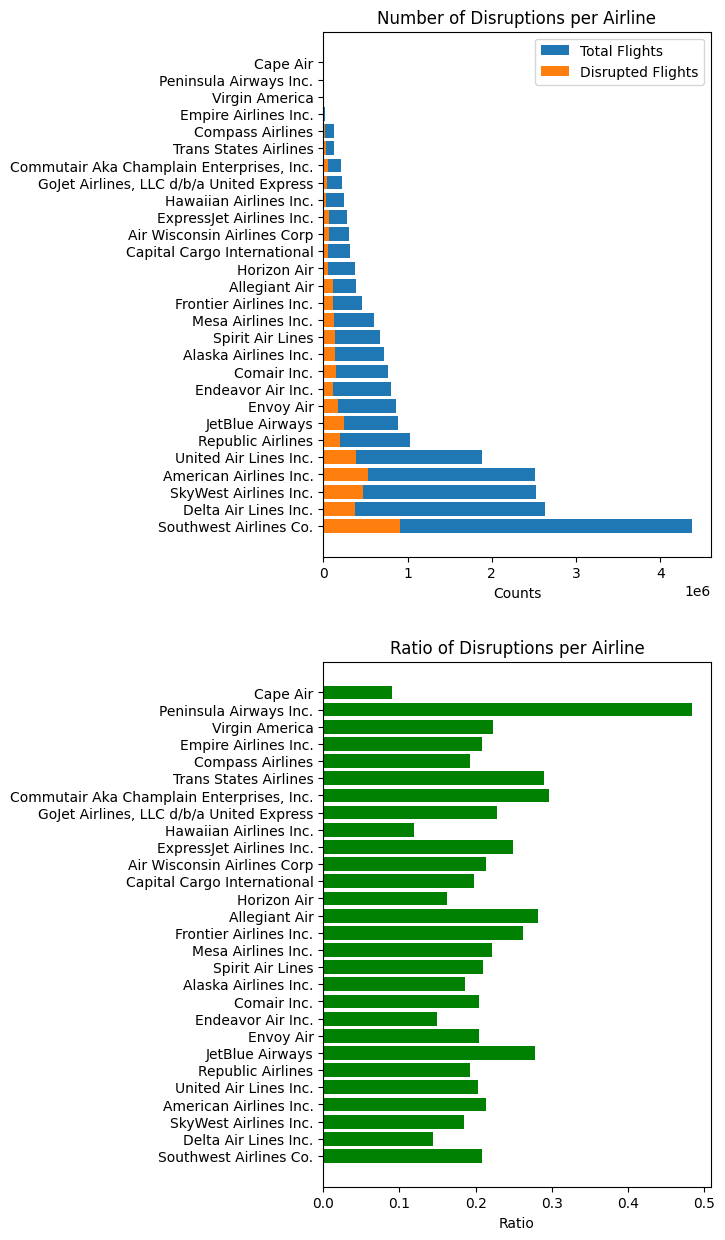

In [4]:
#Chi-square test
crosstab = pd.crosstab(flights_raw['Airline'],flights_raw['Disruption'])
chi2, p, dof, expexcted = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})


# DataaFrame for plot
airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(5,15))
ax1.barh(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.barh(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Counts')
ax1.legend()


ax2.barh(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Ratio')
display(chi2_results);

In [5]:
# Inspect Outlier
airline_data.loc['Peninsula Airways Inc.']

Flights        2219.000000
Disruptions    1075.000000
Ratio             0.484452
Name: Peninsula Airways Inc., dtype: float64

As expected the feature `'Airline'` seems to be a good predicter for a disruption. The rate of disruptions varies noticably between airlines and the chi-squared contingency test gives a p-value of about 0, meaning we conclude a relationship between `'Airline'` and `'Disruption'`. We notice that the airline 'Peninsula Airways Inc.' stands out as an outlier with a rate of disruption of close to 50%. We only have reltively few observations of this airline so we expect there to be more variability in this ratio. We have other airlines with a low frequency in the data that have significantly lower rates of disruption. There doesn't seem to be a reasonable way to group airlines to reduce the number of unique categories, and since there is no logical order to the airlines, label encoding would not make sense as a method of encoding this feature. It makes sense to use taget encoding on this occasion, since the best metric the model can use to predict a disruption based on the airline is to use its historic rate of disrupted flights.

In [6]:
del airline_data, chi2, p, dof, expexcted

### Planes

It is reasonable to believe that an airplane that has caused disruptions in the past will continue to do so in the future. The tail number is a unique identifier for an airplane.

,Variable,Plane
0,Chi-square,261608.547679
1,p-value,0.000000
2,Degrees of Freedom,7087.000000


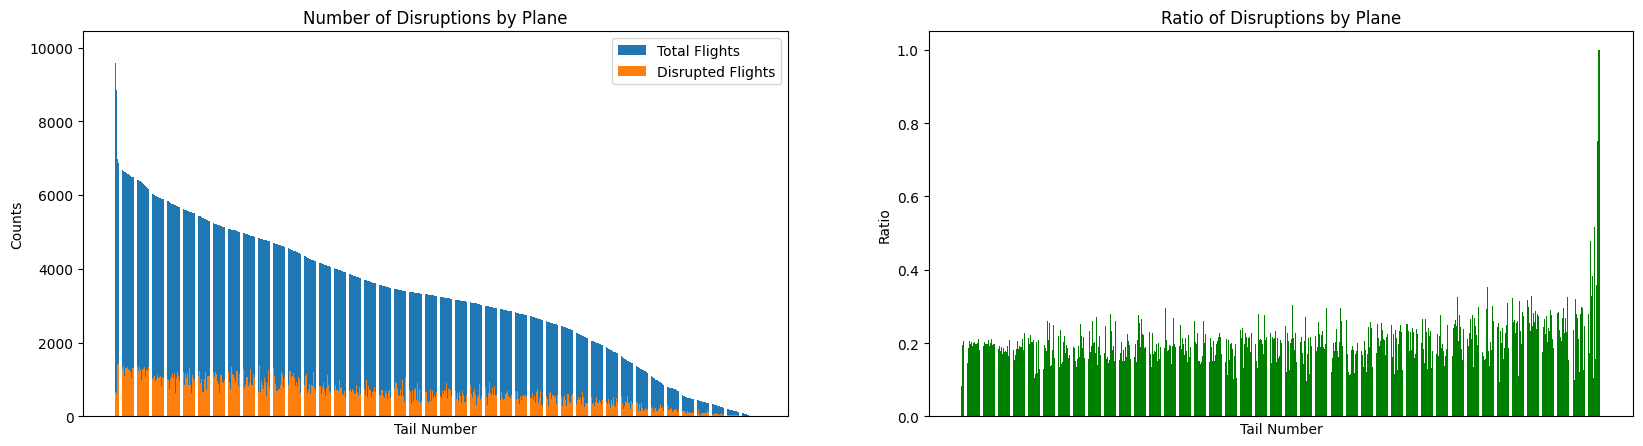

In [7]:
#Conduct chi-squared contingency test for features
chi2_plane, p_plane, dof_plane, expected = chi2_contingency(pd.crosstab(flights_raw['Tail_Number'],flights_raw['Disruption']))
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Plane': [chi2_plane, p_plane, dof_plane],
})

# Calculate data for each plane
plane_data = pd.merge(flights_raw['Tail_Number'].value_counts(),flights_raw.groupby('Tail_Number')['Disruption'].sum(),left_index=True, right_index=True)
plane_data.columns = ["Flights","Disruptions"]
plane_data['Ratio'] = plane_data['Disruptions']/plane_data['Flights']

fig, (ax11,ax12) = plt.subplots(nrows=1,ncols=2,figsize=(20,5))

ax11.bar(plane_data.index, plane_data['Flights'],label='Total Flights')
ax11.bar(plane_data.index, plane_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by Plane')
ax11.set_xlabel('Tail Number')
ax11.set_ylabel('Counts')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.legend()

ax12.bar(plane_data.index, plane_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by Plane')
ax12.set_xlabel('Tail Number')
ax12.set_ylabel('Ratio')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

display(chi2_results);

In [16]:
mask = flights_raw['Tail_Number'].isnull()
display(flights_raw[mask]);

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Quarter,Month,DayOfWeek,Tail_Number,Disruption
14635,Allegiant Air,BOI,LAX,2007,674,2018,1,1,7,NaN,1.0
16928,Hawaiian Airlines Inc.,HNL,LIH,1210,102,2018,1,1,6,NaN,1.0
16946,Hawaiian Airlines Inc.,LIH,HNL,1322,102,2018,1,1,4,NaN,1.0
17642,Hawaiian Airlines Inc.,LIH,HNL,1055,102,2018,1,1,4,NaN,1.0
25012,Frontier Airlines Inc.,SJU,MCO,257,1189,2018,1,1,2,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
23348737,ExpressJet Airlines Inc.,OKC,ORD,1405,693,2019,1,1,2,NaN,1.0
23348738,ExpressJet Airlines Inc.,ORD,CHA,1930,501,2019,1,1,2,NaN,1.0
23348739,ExpressJet Airlines Inc.,ORD,LEX,1430,323,2019,1,1,2,NaN,1.0
23348740,ExpressJet Airlines Inc.,ORD,LEX,1430,323,2019,1,1,3,NaN,1.0


These graphs show significant variablity in the rate of disruptions for different planes. This observation is supported by the chi-squared contingency test. Similarly to the `'Airline'` feature, neither one-hot encoding nor label encoding makes sense in this case, so we will use target encoding. We can see spike in the righ end of the ratio graph. These are all the flights with missing `'Tail_Number'`, which are all disrupted. This means that if the `'Tail_Number'` is misssing our model can be quite certain that the flight is disrupted. The target encoder will treat the missing values as a seperate category and learn this realtionship from the training data.

In [17]:
del plane_data, chi2_plane, p_plane, dof_plane, expected, chi2_results

### Year, Month, Quarter

To assess patterns across the years recorded in the data, we plot the annual, quarterly and monthly disruptions.

,Variable,Year,Quarter,Month
0,Chi-square,97675.431367,34293.951703,104452.466686
1,p-value,0.000000,0.000000,0.000000
2,Degrees of Freedom,4.000000,3.000000,11.000000


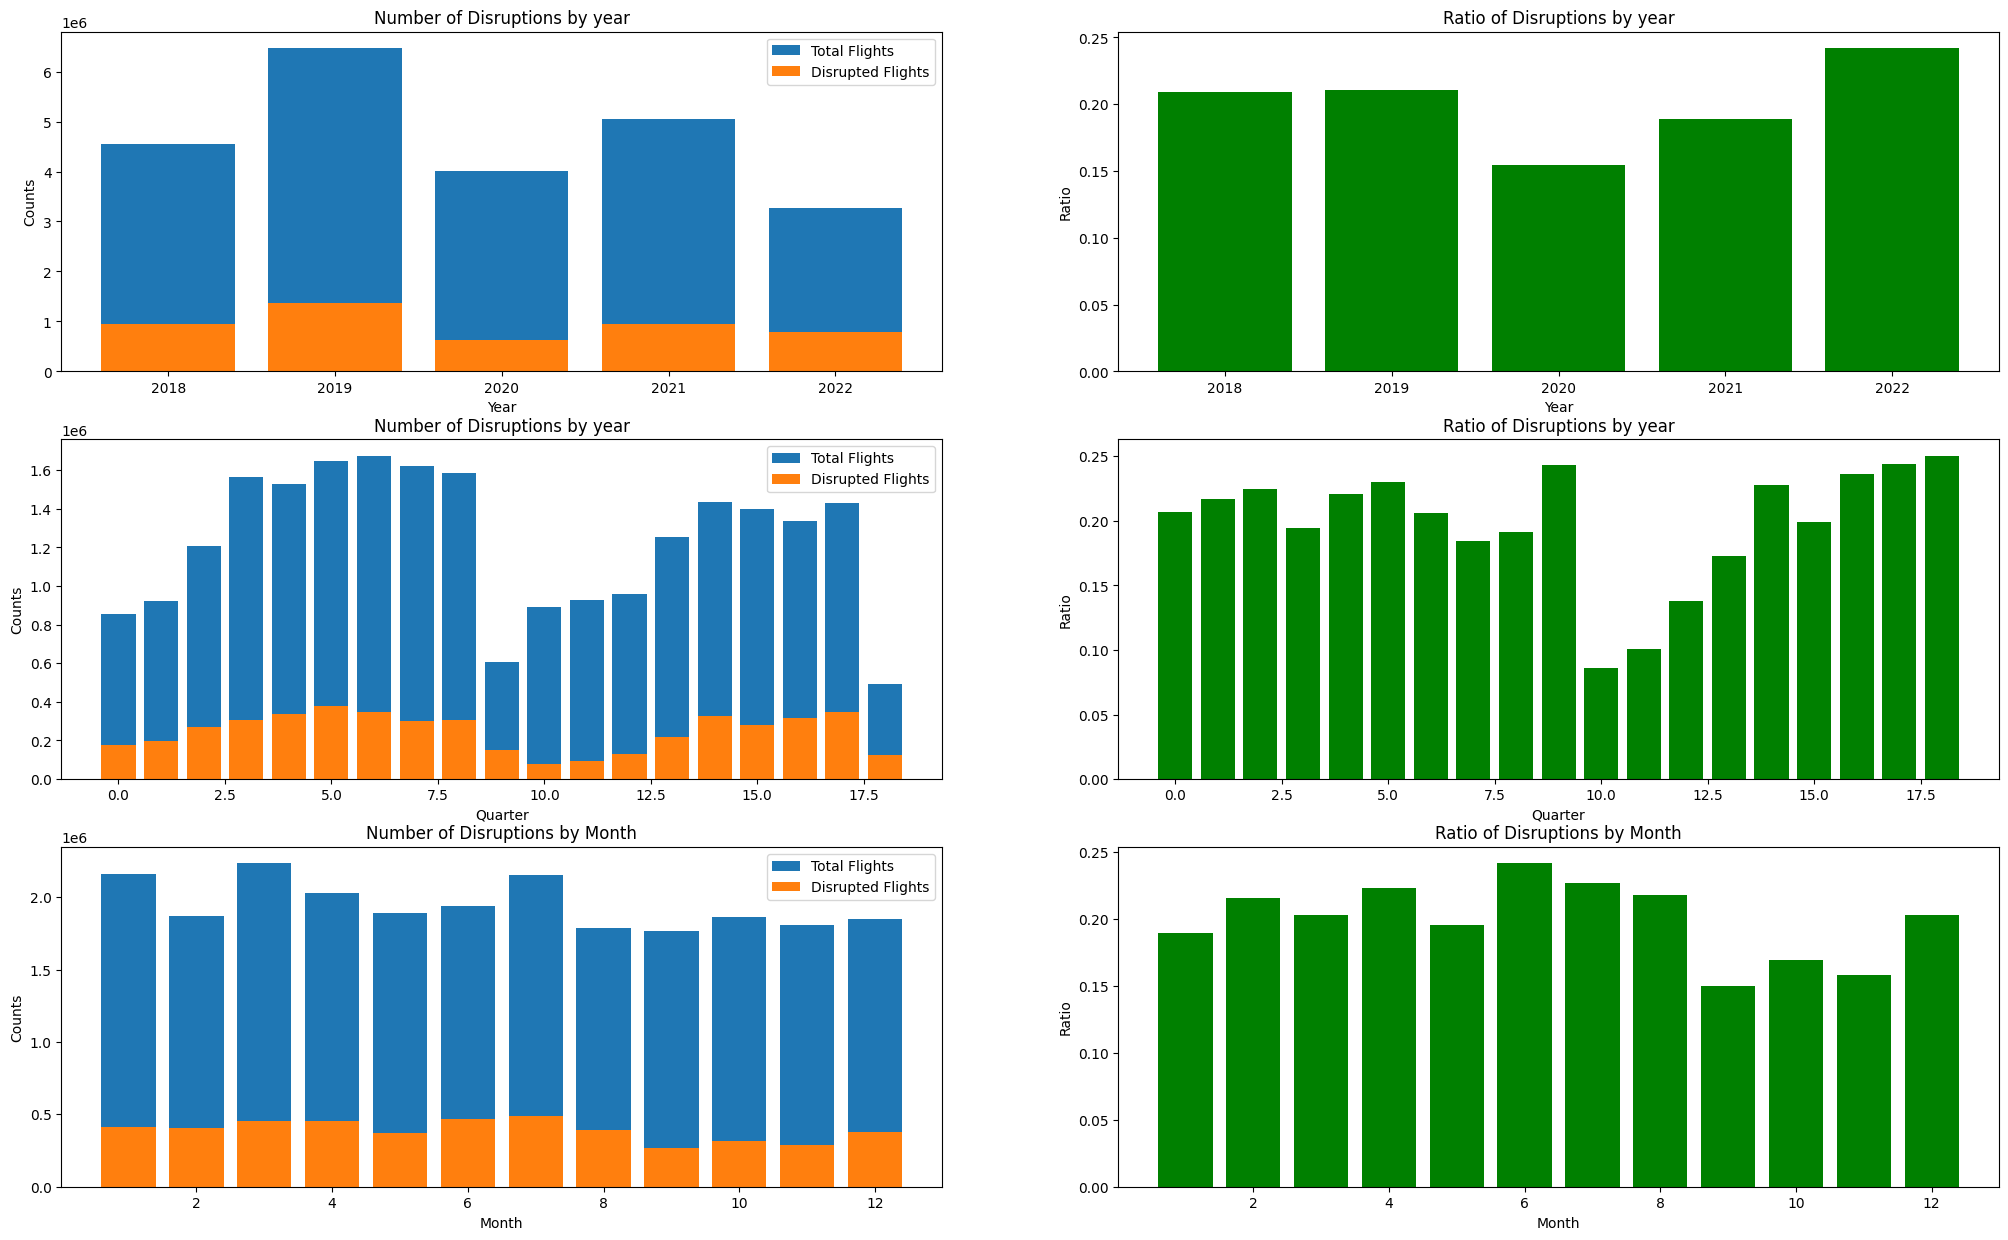

In [18]:
#Conduct chi-squared contingency test for features
chi2_year, p_year, dof_year, expected = chi2_contingency(pd.crosstab(flights_raw['Year'],flights_raw['Disruption']))
chi2_quarter, p_quarter, dof_quarter, expected = chi2_contingency(pd.crosstab(flights_raw['Quarter'],flights_raw['Disruption']))
chi2_month, p_month, dof_month, expected = chi2_contingency(pd.crosstab(flights_raw['Month'],flights_raw['Disruption']))
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'Year': [chi2_year, p_year, dof_year],
    'Quarter': [chi2_quarter, p_quarter, dof_quarter],
    'Month': [chi2_month, p_month, dof_month]
})

#Calculate yearly data for plot
year_data = pd.merge(flights_raw['Year'].value_counts(),flights_raw.groupby('Year')['Disruption'].sum(),left_index=True, right_index=True)
year_data.columns = ["Flights","Disruptions"]
year_data['Ratio'] = year_data['Disruptions']/year_data['Flights']

#Calculate quartely
quarter_data = pd.merge(flights_raw.groupby(['Year','Quarter']).size().reset_index(name='Flights'),
         flights_raw.groupby(['Year','Quarter'])['Disruption'].sum().reset_index(name='Disruptions'),
         left_index=True, right_index=True)
quarter_data['Ratio'] = quarter_data['Disruptions']/quarter_data['Flights']

#Calculate monthly data
month_data = pd.merge(flights_raw['Month'].value_counts(),flights_raw.groupby('Month')['Disruption'].sum(),left_index=True, right_index=True)
month_data.columns = ["Flights","Disruptions"]
month_data['Ratio'] = month_data['Disruptions']/month_data['Flights']


fig, ((ax11,ax12),(ax21,ax22),(ax31,ax32)) = plt.subplots(nrows=3,ncols=2,figsize=(25,15))
ax11.bar(year_data.index, year_data['Flights'],label='Total Flights')
ax11.bar(year_data.index, year_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by year')
ax11.set_xlabel('Year')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(year_data.index, year_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by year')
ax12.set_xlabel('Year')
ax12.set_ylabel('Ratio')

ax21.bar(quarter_data.index, quarter_data['Flights'],label='Total Flights')
ax21.bar(quarter_data.index, quarter_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by year')
ax21.set_xlabel('Quarter')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(quarter_data.index, quarter_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by year')
ax22.set_xlabel('Quarter')
ax22.set_ylabel('Ratio')

ax31.bar(month_data.index, month_data['Flights'],label='Total Flights')
ax31.bar(month_data.index, month_data['Disruptions'], label='Disrupted Flights')
ax31.set_title('Number of Disruptions by Month')
ax31.set_xlabel('Month')
ax31.set_ylabel('Counts')
ax31.legend()


ax32.bar(month_data.index, month_data['Ratio'],color="green")
ax32.set_title('Ratio of Disruptions by Month')
ax32.set_xlabel('Month')
ax32.set_ylabel('Ratio')
display(chi2_results)

The drop in total flights starting from the second quarter of 2020 is due to the covid 19 pandemic. We can see an increse in the rate of disruptions from this point onwards which could be explained be the layoffs in the aviation sector. Since the goal of this project is to predict future disruptions we should not include any features that allow the model to pick up such patterns. Instead the monthly plot shows some seasonality across the year, which makes it a valuable feature to include. The rate of disruptions seems to increase in the summer months. Encoding this feature in a numeric way makes sense as different months have different distances from each other. To show the model that January and December are equally far apart as January and Febuary, we will use cyclical enconding. This technique uses the periodic functions sin and cosine to encode seasonality.

In [19]:
del year_data, quarter_data, month_data, chi2_year, p_year, dof_year, expected,chi2_quarter, p_quarter, dof_quarter, chi2_month, p_month, dof_month, chi2_results

### Day of Week, Time of Day

We will now see whether inclusing the time and weekday of the flight in our model.

,Variable,DayOfWeek,TimeOfDay
0,Chi-square,24720.764935,376049.311374
1,p-value,0.000000,0.000000
2,Degrees of Freedom,6.000000,23.000000


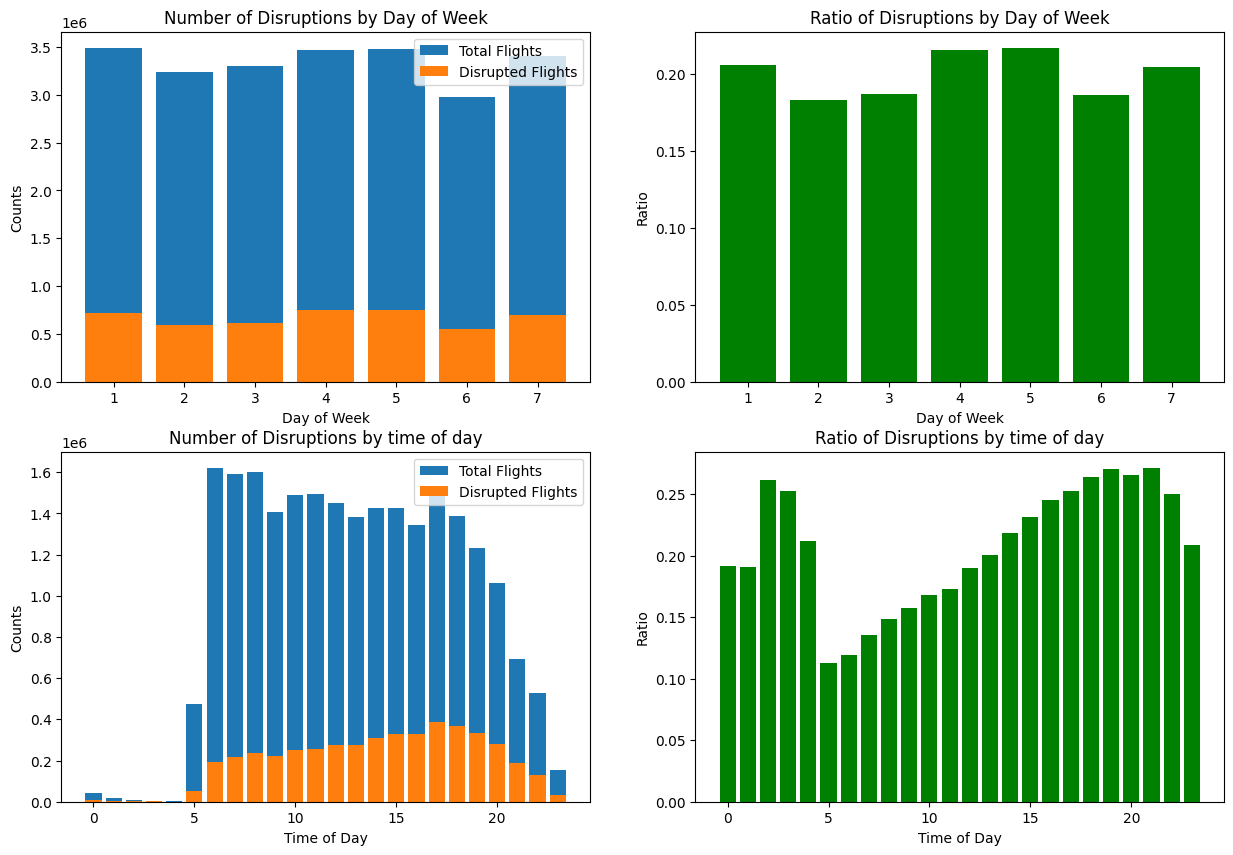

In [20]:
# Devide by 100 to plot time with 24 bins for each hour
flights_raw['TimeOfDay'] = flights_raw['CRSDepTime'] // 100

#Chi-square test
crosstab = pd.crosstab(flights_raw['DayOfWeek'],flights_raw['Disruption'])
chi2_day, p_day, dof_day, expected = chi2_contingency(crosstab)
crosstab = pd.crosstab(flights_raw['TimeOfDay'],flights_raw['Disruption'])
chi2_time, p_time, dof_time, expected = chi2_contingency(crosstab)
chi2_results = pd.DataFrame({
    'Variable': ['Chi-square', 'p-value', 'Degrees of Freedom'],
    'DayOfWeek': [chi2_day, p_day, dof_day],
    'TimeOfDay': [chi2_time, p_time, dof_time]
})

day_data = pd.merge(flights_raw['DayOfWeek'].value_counts(),
                     flights_raw.groupby('DayOfWeek')['Disruption'].sum(),
                     left_index=True, right_index=True)
day_data.columns = ["Flights","Disruptions"]
day_data['Ratio'] = day_data['Disruptions']/day_data['Flights']


time_data = pd.merge(flights_raw['TimeOfDay'].value_counts(),
                     flights_raw.groupby('TimeOfDay')['Disruption'].sum(),
                     left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

ax11.bar(day_data.index, day_data['Flights'],label='Total Flights')
ax11.bar(day_data.index, day_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by Day of Week')
ax11.set_xlabel('Day of Week')
ax11.set_ylabel('Counts')
ax11.legend()


ax12.bar(day_data.index, day_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by Day of Week')
ax12.set_xlabel('Day of Week')
ax12.set_ylabel('Ratio')


ax21.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax21.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by time of day')
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Counts')
ax21.legend()


ax22.bar(time_data.index, time_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by time of day')
ax22.set_xlabel('Time of Day')
ax22.set_ylabel('Ratio')

display(chi2_results)

The rate of disruptions seems to vary slightly across different days of the week. Since this variability is small compared to the other features we have seen, and to keep a reasonable amount of features we will not include `'DayOfWeek'` in the model.

The `'TimeOfDay'` seems to be a strong predicter for a disruption. We can see that the rate of disruptions increases throughout the day and is highest between midnight and 4 AM. For the same reason as for the `'Months'` we will use cyclical encoding for this feature. 

In [21]:
del day_data, time_data, chi2_day, p_day, dof_day, expected, chi2_time, p_time, dof_time, chi2_results

### Origin Airport and Destination Airport 

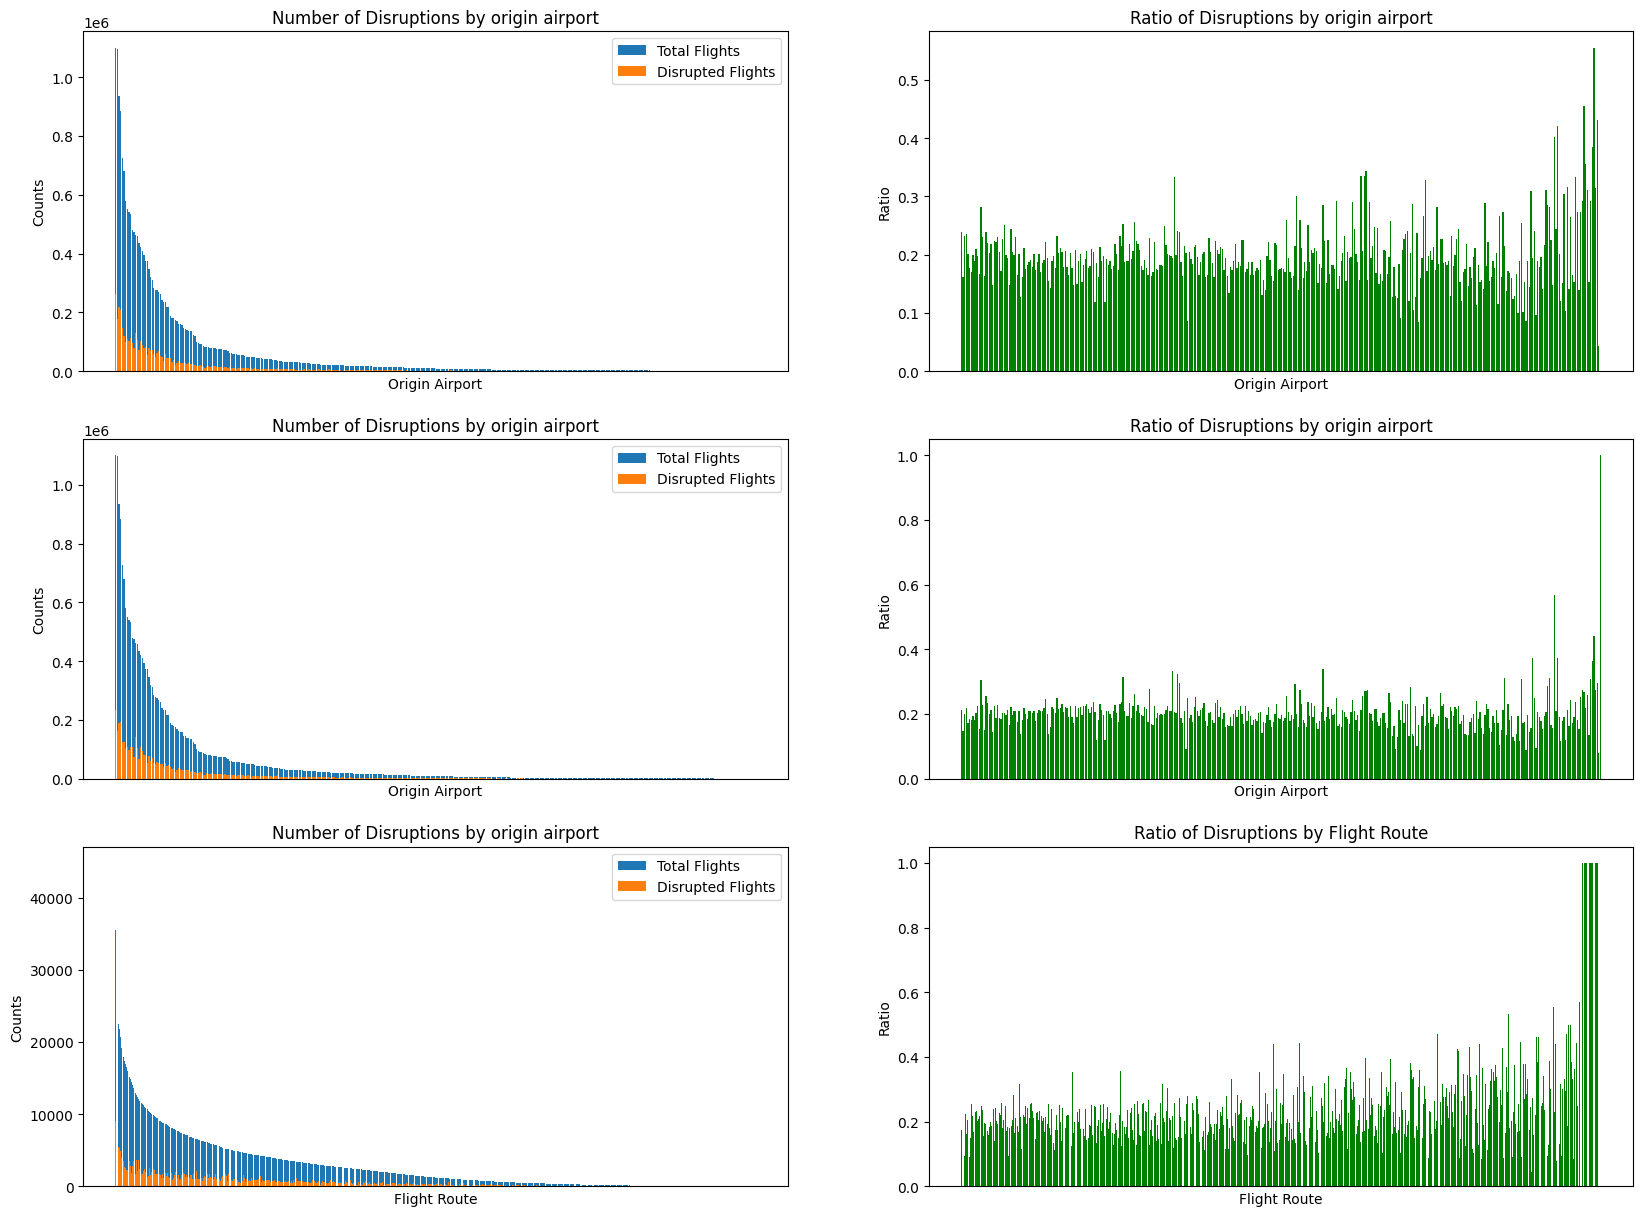

In [24]:
# Calculate data for origin airport
origin_data = pd.merge(flights_raw['Origin'].value_counts(),
                       flights_raw.groupby('Origin')['Disruption'].sum(),
                       left_index=True, right_index=True)
origin_data.columns = ["Flights", "Disruptions"]
origin_data['Ratio'] = origin_data['Disruptions']/origin_data['Flights']

# Calculate data for destination airport
dest_data = pd.merge(flights_raw['Dest'].value_counts(),
                       flights_raw.groupby('Dest')['Disruption'].sum(),
                       left_index=True, right_index=True)
dest_data.columns = ["Flights", "Disruptions"]
dest_data['Ratio'] = dest_data['Disruptions']/dest_data['Flights']


# Make new 'Route' column
flights_raw['Route'] = flights_raw['Origin'] + '->' + flights_raw['Dest']

# Calculate route data
route_data = pd.merge(flights_raw['Route'].value_counts(),
                       flights_raw.groupby('Route')['Disruption'].sum(),
                       left_index=True, right_index=True)
route_data.columns = ["Flights", "Disruptions"]
route_data['Ratio'] = route_data['Disruptions']/route_data['Flights']


# Plot results
fig, ((ax11,ax12), (ax21,ax22), (ax31,ax32)) = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

# Origin Plots
ax11.bar(origin_data.index, origin_data['Flights'],label='Total Flights')
ax11.bar(origin_data.index, origin_data['Disruptions'], label='Disrupted Flights')
ax11.set_title('Number of Disruptions by origin airport')
ax11.set_xlabel('Origin Airport')
ax11.set_ylabel('Counts')
ax11.legend()
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax12.bar(origin_data.index, origin_data['Ratio'],color="green")
ax12.set_title('Ratio of Disruptions by origin airport')
ax12.set_xlabel('Origin Airport')
ax12.set_ylabel('Ratio')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Destination Plots
ax21.bar(dest_data.index, dest_data['Flights'],label='Total Flights')
ax21.bar(dest_data.index, dest_data['Disruptions'], label='Disrupted Flights')
ax21.set_title('Number of Disruptions by origin airport')
ax21.set_xlabel('Origin Airport')
ax21.set_ylabel('Counts')
ax21.legend()
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax22.bar(dest_data.index, dest_data['Ratio'],color="green")
ax22.set_title('Ratio of Disruptions by origin airport')
ax22.set_xlabel('Origin Airport')
ax22.set_ylabel('Ratio')
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Route Plots
ax31.bar(route_data.index, route_data['Flights'],label='Total Flights')
ax31.bar(route_data.index, route_data['Disruptions'], label='Disrupted Flights')
ax31.set_title('Number of Disruptions by Flight Route')
ax31.set_xlabel('Flight Route')
ax31.set_ylabel('Counts')
ax31.legend()
ax31.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax32.bar(route_data.index, route_data['Ratio'],color="green")
ax32.set_title('Ratio of Disruptions by Flight Route')
ax32.set_xlabel('Flight Route')
ax32.set_ylabel('Ratio')
ax32.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

All three features `'Dest'`, `'Origin'` and `'Route'` show promising levels of variability. Since the `'Route'` feature has the most variablity, with some routes having a disruption rate of 1.0, and since this feature summarises the other two features, we will only include this feature in the model. For the same reasons as for the `'Tail_Number'` and `'Airline'` features we will use target encoding.

In [25]:
del origin_data, dest_data, route_data

### Distance
The final feature we will investigate is the distance of the flight. This is the only numeric feature which is not cylclical so we can calculate the correlation. Additionally, we will look at histograms to assess whether this is a feature worth including.

,Distance,Disruption
Distance,1.00000,0.01229
Disruption,0.01229,1.00000


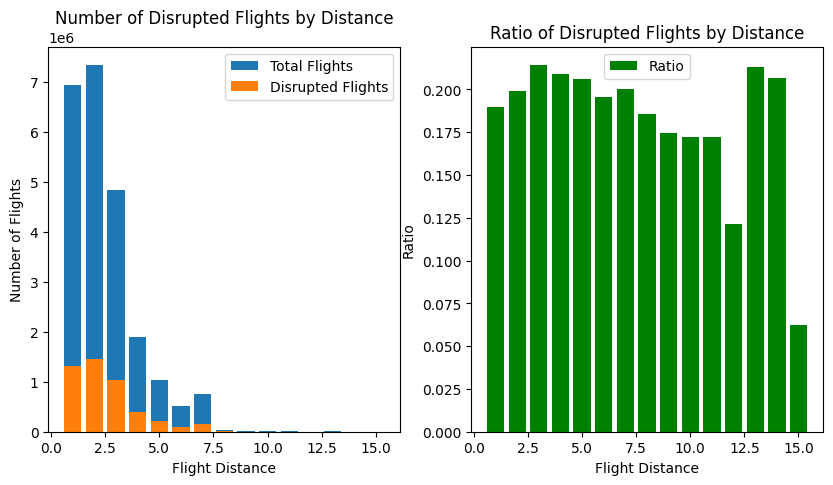

In [27]:
#Split the distances into 10 groups
flights_raw['Distance_Group'] = pd.cut(flights_raw['Distance'], bins=15,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
distance_data = pd.merge(flights_raw['Distance_Group'].value_counts(),flights_raw.groupby('Distance_Group')['Disruption'].sum(),left_index=True, right_index=True)
distance_data.columns = ["Flights","Disruptions"]


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(distance_data.index,distance_data['Flights'], label='Total Flights')
ax1.bar(distance_data.index,distance_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Flight Distance')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Distance')
ax1.legend()

ax2.bar(distance_data.index,distance_data['Disruptions']/distance_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Flight Distance')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Distance')
ax2.legend()

display(flights_raw[['Distance','Disruption']].corr());

We can see that most flights cover quite a short distance, as this data only contains US domestic flights. For the correlation between `'Distance'` and `'Disruption'` we calculate a relatively low value of 0.01229. Additionally it seems plausible that our `'Route'` feature captures a lot of the same information so we will not include this feature in the model.

In [28]:
del distance_data

### Summary
* Rename `'CRSDepTime'` to `'TimeOfDay'`
* Construct `'Route'` feature from `'Origin'` and `'Dest'`
* Include `'Airline'`, `'Route'`, `'TimeOfDay'`, `'Month'` and `'Tail_Number'`
* Use cyclical encoding for `'TimeOfDay'` and `'Month'`
* Use target encoding for `'Route'`, `'Airline'` and `'Tail_Number'`

## Feature Engineering and Preprocessing

In [6]:
#Rename 'CRSDepTime' column to 'TimeOfDay'
flights = flights_raw.rename({'CRSDepTime':'TimeOfDay'},axis=1, inplace=False)


#Make 'Route' column
flights['Route'] = flights['Origin'] + '->' + flights['Dest']

#List of features to include in our model
features = ['Airline', 'Route', 'TimeOfDay', 'Month' ,'Tail_Number' ,'Disruption']


#Group features by how we will encode them
cyclical_encode_features = ['TimeOfDay',  'Month']
target_encode_features = ['Route', 'Airline', 'Tail_Number']

#Define a custom encoder for the 'TimeOfDay' amd 'Month' features. This will preserve distances between times of day.
class CyclicalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['Time_sin'] = np.sin(2 * np.pi * X_transformed['TimeOfDay'] / 2400)
        X_transformed['Time_cos'] = np.cos(2 * np.pi * X_transformed['TimeOfDay'] / 2400)
        X_transformed['Month_sin'] = np.sin(2 * np.pi * X_transformed['Month'] / 7)
        X_transformed['Month_cos'] = np.cos(2 * np.pi * X_transformed['Month'] / 7)
        return X_transformed.drop(['TimeOfDay', 'Month'], axis=1)
        
    def fit_transform(self, X, y=None):
        return self.transform(X)

#Define training set and split of labels
X = flights[features].drop('Disruption', axis = 1)
y = flights['Disruption']

#Define training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state=17)


#Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), target_encode_features),
        ('cyclical', CyclicalTransformer(), cyclical_encode_features),
    ],
    remainder='passthrough'
)

del flights_raw
del X
del y

## Model Training and Hyperparameter Tuning
We will first fit a Stochastic Gradient Descent, Random Forest and Histogram Gradient Boosting Classifier. For the Random Forest Classifier we use more conservative hyperparameters to account for the amount of data we have. We choose the Histogram Gradient Boosting due to its ability to deal with large datasets. For each model we use 0.5 as an intial threshold.

#### Model 1: Stochastic Gradient Descent 

In [7]:
# Set pipeline
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss = 'log_loss', n_jobs=-1))
])
# Train model
sgd_pipeline.fit(X_train,y_train);

Precision: 0.9971910112359551
Recall: 0.04584588893671976
f1-score: 0.08766153592888302
Accuracy: 0.8101615955743194


<Axes: >

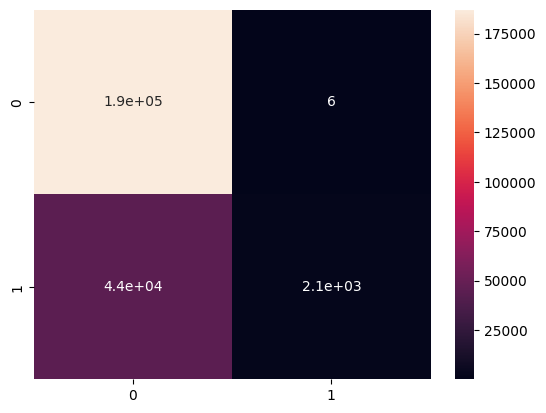

In [48]:
# Threshold for a positive prediction
threshold = 0.5

y_scores_sgd = sgd_pipeline.predict_proba(X_val) # predicted probabilities
y_predictions_sgd = np.where(y_scores_sgd[:,1] >= threshold, 1, 0) # predicitons based on the threshold
conf_mat = confusion_matrix(y_val, y_predictions_sgd) # calculate confusion matrix

# Calculate metrics
precision = conf_mat[1,1]/sum(conf_mat[:,1])
recall = conf_mat[1,1]/sum(conf_mat[1,:])
f1_score = 2*precision*recall/(precision+recall)
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

#### Model 2: Random Forest Classifier

In [29]:
# Define Random Forest Pipeline with reduced parameters to speeed up comuptation
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=10,
                                          max_depth=15,
                                          min_samples_leaf=5,
                                          n_jobs=-1))
])

# Train model on training data
rf_pipeline.fit(X_train,y_train);

Precision: 0.9198936977980258
Recall: 0.052152389151958675
f1-score: 0.09870859982889967
Accuracy: 0.8105383950056948


<Axes: >

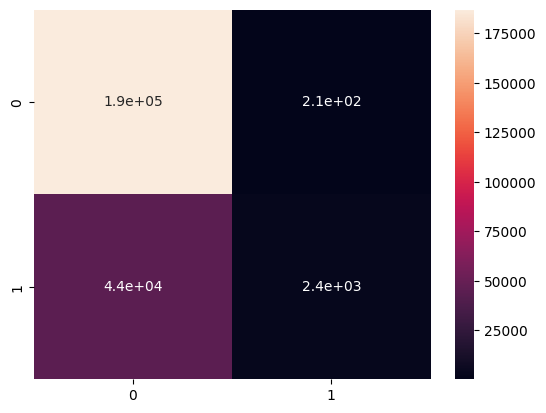

In [51]:
threshold = 0.5

y_scores_rf = rf_pipeline.predict_proba(X_val)
y_predictions_rf = np.where(y_scores_rf[:,1]>=threshold, 1, 0)
conf_mat = confusion_matrix(y_val, y_predictions_rf)

precision = conf_mat[1,1]/sum(conf_mat[:,1])
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

#### Model 3 Hist Gradient Boosting Classifier

In [31]:
# Define Random Forest Pipeline with reduced parameters to speeed up comuptation
hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier())
])
# Trian on training data
hgb_pipeline.fit(X_train,y_train);

Precision: 0.8785529715762274
Recall: 0.05122686181661645
f1-score: 0.09680896499827127
Accuracy: 0.8098490233187466


<Axes: >

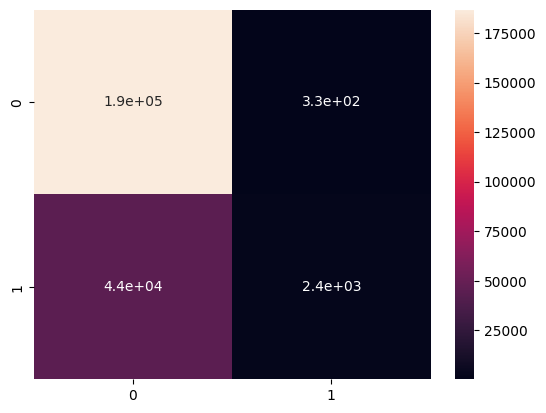

In [45]:
threshold = 0.5
y_scores_hgb = hgb_pipeline.predict_proba(X_val)
y_predictions_hgb = np.where(y_scores_hgb[:,1]>=threshold,1,0)
conf_mat = confusion_matrix(y_val, y_predictions_hgb)

precision = conf_mat[1,1]/sum(conf_mat[:,1])
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall) 


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

### Model Comparison

#### Lift Curve

We use the lift curve to assess the effectiveness of each model by comparing its performance against a baseline model.

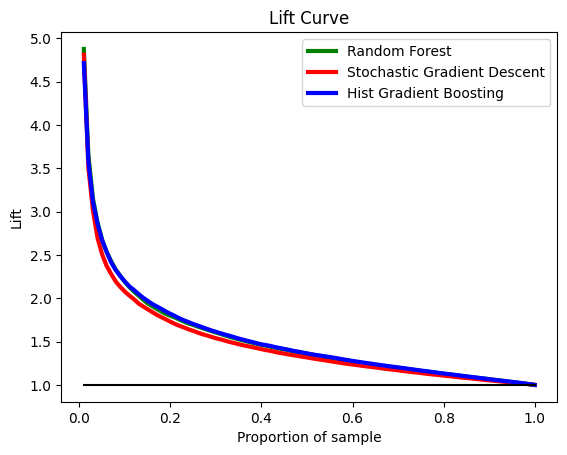

In [38]:
def calc_lift(y_val, y_pred, step=0.01):
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted',ascending=False,inplace=True)  # Order the values for the predicted probability column   
    x_val = np.arange(step,1+step,step) # Create the values that will go into the X axis of our plot
    ratio_ones = aux_lift['real'].sum() / len(aux_lift) # Calculate the ratio of ones in our data
    y_v = []
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) 
        data_here = aux_lift.iloc[:num_data,:]
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val, y_v


sample_prop, lift_rf = calc_lift(y_val, y_scores_rf[:,1], step=0.01)
sample_prop, lift_sgd = calc_lift(y_val, y_scores_sgd[:,1], step=0.01)
sample_prop, lift_hgb = calc_lift(y_val, y_scores_hgb[:,1], step=0.01)

#Plot the figure
fig, axis = plt.subplots()
fig.figsize = (40,40)
axis.plot(sample_prop, lift_rf, 'g-', linewidth = 3, markersize = 5, label='Random Forest')
axis.plot(sample_prop, lift_sgd, 'r-', linewidth = 3, markersize = 5, label='Stochastic Gradient Descent')
axis.plot(sample_prop, lift_hgb, 'b-', linewidth = 3, markersize = 5, label='Hist Gradient Boosting')
axis.plot(sample_prop, np.ones(len(sample_prop)), 'k-')
axis.set_xlabel('Proportion of sample')
axis.set_ylabel('Lift')
plt.legend()
plt.title('Lift Curve')
plt.show()

All three models are above a lift of 1.0 for all proportions of the sample, suggesting all perform better than a random model.

#### ROC Curve

We plot the ROC curve to have a futher metric to compare the models on.

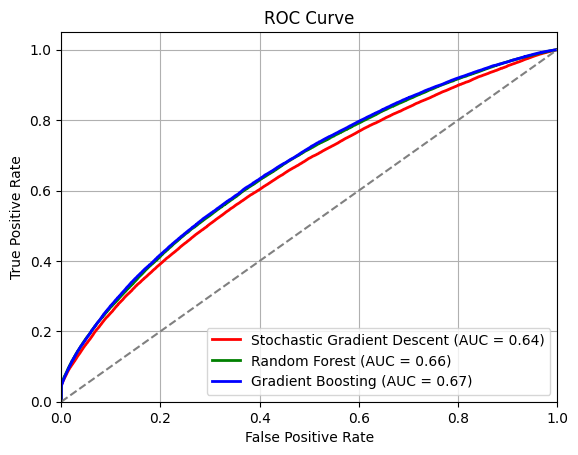

In [40]:
fpr_sgd, tpr_sgd, thresholds = roc_curve(y_val, y_scores_sgd[:,1])
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_scores_rf[:,1])
fpr_hgb, tpr_hgb, thresholds = roc_curve(y_val, y_scores_hgb[:,1])

# Compute AUC (Area Under the Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
roc_auc_hgb = auc(fpr_hgb, tpr_hgb)


# Plot ROC curve
plt.plot(fpr_sgd, tpr_sgd, color='red', lw=2, label='Stochastic Gradient Descent (AUC = %0.2f)' % roc_auc_sgd)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_hgb, tpr_hgb, color='blue', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_hgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

All three models perform better than the baseline and the Gradient Boosting Classifier has the highest area under the curve.

#### Precision Recall vs Threshold

We plot the precision-recall vs threshold curve to assess which threshold to choose to meet our goal of 0.9 recall

Text(0.5, 1.0, 'Stochastic Gradient Descent')

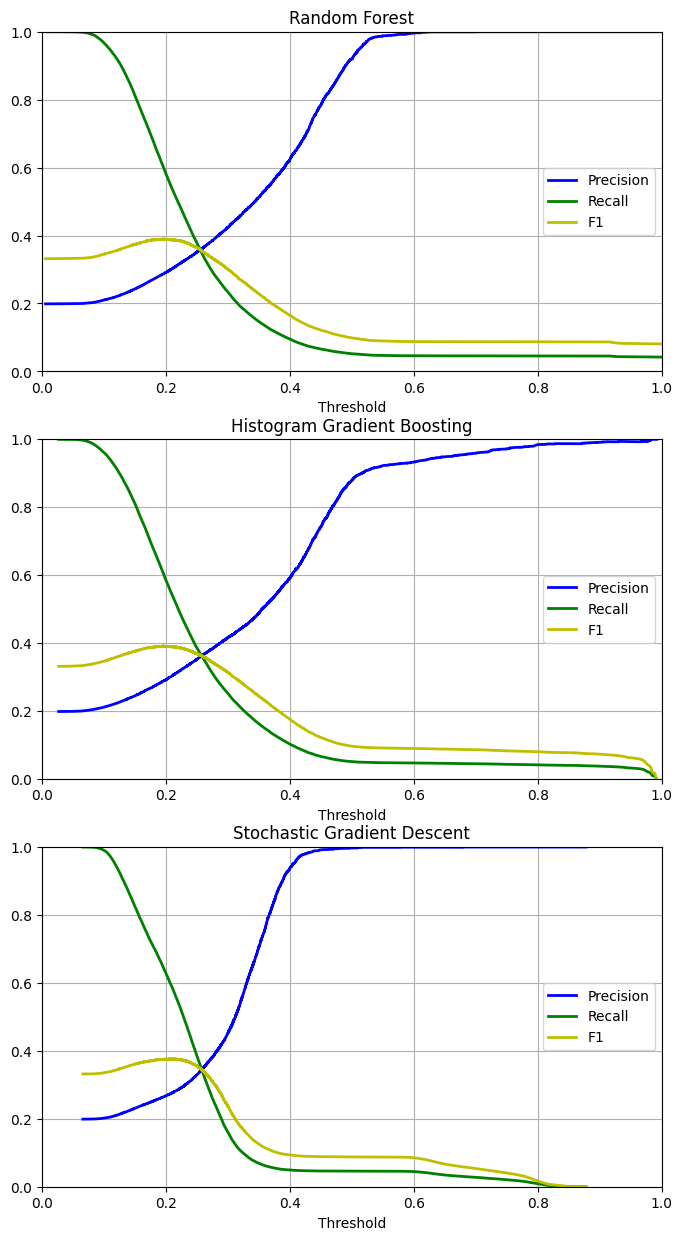

In [43]:
# Get precisions, recalls and thresholds for each model
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_val, y_scores_rf[:,1])
precisions_hgb, recalls_hgb, thresholds_hgb = precision_recall_curve(y_val, y_scores_hgb[:,1])
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_val, y_scores_sgd[:,1])

# Calculate thresholds for each model
f1_scores_rf = 2 * precisions_rf * recalls_rf / (precisions_rf + recalls_rf)
f1_scores_hgb = 2 * precisions_hgb * recalls_hgb / (precisions_hgb + recalls_hgb)
f1_scores_sgd = 2 * precisions_sgd * recalls_sgd / (precisions_sgd + recalls_sgd)



# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1,figsize=(8,15))

# Plot Random Forest
ax1.plot(
    thresholds_rf,
    precisions_rf[:-1], "b",
    label="Precision",
    linewidth=2)
ax1.plot(
    thresholds_rf,
    recalls_rf[:-1], "g",
    label="Recall",
    linewidth=2)
ax1.plot(
    thresholds_rf,
    f1_scores_rf[:-1], "y",
    label="F1",
    linewidth=2)
ax1.legend(loc="center right", fontsize=10)
ax1.set_xlabel("Threshold", fontsize=10)
ax1.grid(True)
ax1.axis([0, 1, 0, 1])
ax1.set_title('Random Forest')


# Plot Histogram Gradinet Boost
ax2.plot(
    thresholds_hgb,
    precisions_hgb[:-1], "b",
    label="Precision",
    linewidth=2)
ax2.plot(
    thresholds_hgb,
    recalls_hgb[:-1], "g",
    label="Recall",
    linewidth=2)
ax2.plot(
    thresholds_hgb,
    f1_scores_hgb[:-1], "y",
    label="F1",
    linewidth=2)
ax2.legend(loc="center right", fontsize=10)
ax2.set_xlabel("Threshold", fontsize=10)
ax2.grid(True)
ax2.axis([0, 1, 0, 1])
ax2.set_title('Histogram Gradient Boosting')



# Plot Stochastic Gradient Descent
ax3.plot(
    thresholds_sgd,
    precisions_sgd[:-1], "b",
    label="Precision",
    linewidth=2)
ax3.plot(
    thresholds_sgd,
    recalls_sgd[:-1], "g",
    label="Recall",
    linewidth=2)
ax3.plot(
    thresholds_sgd,
    f1_scores_sgd[:-1], "y",
    label="F1",
    linewidth=2)
ax3.legend(loc="center right", fontsize=10)
ax3.set_xlabel("Threshold", fontsize=10)
ax3.grid(True)
ax3.axis([0, 1, 0, 1])
ax3.set_title('Stochastic Gradient Descent')

We make the following conclusions:
* The `'RandomForestClassifier'` achieves the highest recall and f1 score.
* The `'SGDClassifier'` has the highest precision but identifies the fewest true positives.
* The `'HistGradientBoostingClassifier'` has the highest AUC.

Since we aim to achieve a recall of at least 90% we will continue fine tuning the Random Forest Classifier. The precision recall vs. threshold shows that we will have to decrease the threshold to about 0.1. This means we will predict a disruption if we are 10% certain.

In [ ]:
del sgd_pipeline
del hgb_pipeline

### Hyperparameter Tuning

We will use random grid search for hyperparameter tuning. This improves efficiency as we don't exhaustively check every single combination. We will also sample from the data as running randomised search on the entire data would cost too much memory. 

In [56]:
# Specify paramter distribution
param_dist = {
    'classifier__n_estimators': randint(5,25),
    'classifier__max_depth': randint(5,25),
    'classifier__min_samples_split': randint(2,10),
    'classifier__min_samples_leaf': randint(1,10)
}

# Sample from the data
flights_gscv_subsample  = flights.sample(n=1000000, random_state=17)
X_subsample = flights_gscv_subsample[features].drop('Disruption', axis = 1)
y_subsample = flights_gscv_subsample['Disruption']

# Randomised search with recall as scoring criterion
rand_search = RandomizedSearchCV(estimator = rf_pipeline, param_distributions=param_dist, cv=3, n_iter=36, scoring='recall', n_jobs=-1)
rand_search.fit(X_subsample, y_subsample)

best_params_rf, best_score_rf = rand_search.best_params_, rand_search.best_score_
best_params_rf, best_score_rf

({'classifier__max_depth': 23,
  'classifier__min_samples_leaf': 6,
  'classifier__min_samples_split': 9,
  'classifier__n_estimators': 5},
 0.07973724261153864)

In [57]:
# train Random Forest on new parameters
rf_pipeline.set_params(**best_params_rf)
rf_pipeline.fit(X_train, y_train);

Precision: 0.21746634972065348
Recall: 0.9274429616874731
f1-score: 0.3523207182309149
Accuracy: 0.32166254185470955


<Axes: >

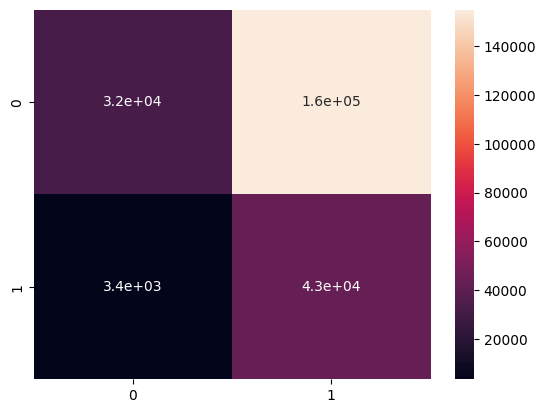

In [60]:
# Set new threshold to 0.1
threshold = 0.1

y_scores_rf = rf_pipeline.predict_proba(X_val)
y_predictions_rf = np.where(y_scores_rf >= threshold, 1, 0)
conf_mat = confusion_matrix(y_val, y_predictions_rf[:,1])
precision = conf_mat[1,1]/sum(conf_mat[:,1])
recall = conf_mat[1,1]/sum(conf_mat[1,:])
f1_score = 2*precision*recall/(precision+recall) 
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1-score: {f1_score}')
print(f'Accuracy: {accuracy}')
sns.heatmap(conf_mat, annot=True)

## Evaluation

We will now test the model on the provided test data.

### Load Test Data

In [61]:
# Remove training and validation data to save memory
del flights
del X_train
del y_train
del X_val
del y_val

In [62]:
# Lists of features and corresponding indeces (note these don't match in the test data)
features = ['Airline','Route', 'TimeOfDay', 'Month', 'Tail_Number','Disruption']
features_index = [1,2,3,4,6,7,8,9,11,20,44]

# Define function to read test data
def import_large(path, features, features_index):   
    data = pd.read_csv(path)
    data.reset_index(inplace=True)
    data = data.iloc[:,features_index]
    data.columns = features
    return data
    
path_to_data = '/cs/datasets/ID5059/Coursework1/4_huge/'
test_csv_names = ['Combined_Flights_test_2018.csv',
                  'Combined_Flights_test_2019.csv',
                  'Combined_Flights_test_2020.csv',
                  'Combined_Flights_test_2021.csv',
                  'Combined_Flights_test_2022.csv'] 
data = []
for csv_name in test_csv_names:
    full_path = path_to_data + csv_name
    year_data = import_large(full_path,['Airline','Origin', 'Dest','CRSDepTime','Distance', 'Year','Quarter', 'Month','DayOfWeek','Tail_Number','Disruption'],features_index)
    data.append(year_data)
flights_test = pd.concat(data,ignore_index=True)
flights_test = flights_test.dropna()

#Rename 'CRSDepTime' column to 'TimeOfDay'
flights_test.rename({'CRSDepTime':'TimeOfDay'},axis=1, inplace=True)

#Make 'Route' column
flights_test['Route'] = flights_test['Origin'] + '->' + flights_test['Dest']


# Choose featurs and split of labels
flights_test = flights_test.loc[:,features]
X_test = flights_test[features].drop('Disruption', axis = 1)
y_test = flights_test['Disruption']


display(flights_test);

,Airline,Route,TimeOfDay,Month,Tail_Number,Disruption
0,Alaska Airlines Inc.,AUS->SFO,600,9,N362VA,0.0
1,SkyWest Airlines Inc.,LAX->MRY,1110,10,N965SW,0.0
2,JetBlue Airways,CHS->DCA,1450,5,N247JB,1.0
3,United Air Lines Inc.,ORD->IAH,2110,12,N826UA,0.0
4,United Air Lines Inc.,BWI->SFO,1905,7,N4888U,0.0
...,...,...,...,...,...,...
5838749,Southwest Airlines Co.,PHX->BNA,1555,5,N8663A,0.0
5838750,United Air Lines Inc.,ORD->PIT,1805,7,N414UA,1.0
5838751,Envoy Air,ORD->GRR,2040,4,N271NN,0.0
5838752,Frontier Airlines Inc.,XNA->DEN,1327,6,N238FR,1.0


### Test Score

,Value,Random Forest,Naive Forest
0,Precision,0.210553,0.193061
1,Recall,0.921774,1.000000
2,F1 score,0.342802,0.323639
3,Accuracy,0.317661,0.193061


<Axes: >

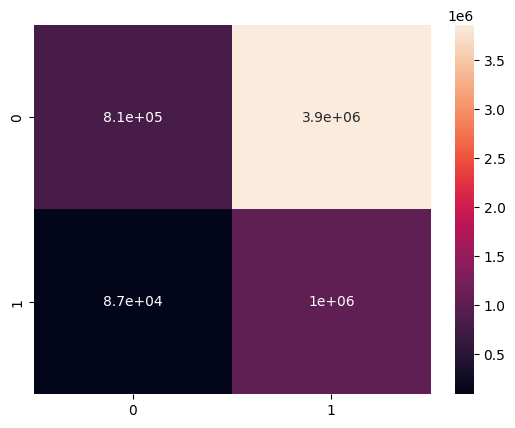

In [64]:
threshold = 0.10

y_scores_rf = rf_pipeline.predict_proba(X_test)
y_pred_rf = np.where(y_scores_rf[:,1] > threshold, 1,0)
conf_mat = confusion_matrix(y_test, y_pred_rf)

precision = conf_mat[1,1]/sum(conf_mat[:,1])
recall = conf_mat[1,1]/sum(conf_mat[1,:])
accuracy = (conf_mat[0,0]+conf_mat[1,1])/(sum(conf_mat[0,:])+sum(conf_mat[1,:]))
f1_score = 2*precision*recall/(precision+recall)

y_pred_naive = np.ones(X_test.shape[0])
conf_mat_naive = confusion_matrix(y_test, y_pred_naive)
precision_naive = conf_mat_naive[1,1]/sum(conf_mat_naive[:,1])
recall_naive = conf_mat_naive[1,1]/sum(conf_mat_naive[1,:])
accuracy_naive = (conf_mat_naive[0,0]+conf_mat_naive[1,1])/(sum(conf_mat_naive[0,:])+sum(conf_mat_naive[1,:]))
f1_score_naive = 2*precision_naive*recall_naive/(precision_naive+recall_naive)

results = pd.DataFrame({
    'Value': ['Precision', 'Recall', 'F1 score', 'Accuracy'],
    'Random Forest': [precision, recall, f1_score, accuracy],
    'Naive Model': [precision_naive, recall_naive, f1_score_naive, accuracy_naive]
})

display(results)
sns.heatmap(conf_mat, annot=True)

* The final model achieves the goal of a recall of at least 90%.
* If the model predicts a disruption it is correct 21.06% of the times.
* In total the model has an accuracy of 31.76%
* The Random Forest Model beats a naive model in every metric